# Pre-requisites

In [35]:
#install.packages("tidyverse")
#install.packages("stringr")
#install.packages("readr")
#install.packages("dplyr")
#install.packages("datetime")
#install.packages("ggplot2")


The downloaded binary packages are in
	/var/folders/fs/mlq8k09d4pdfcrblj2nqvvwm0000gn/T//RtmpuC8Mb7/downloaded_packages


In [6]:
library(readr)
library(stringr) # to hand strings
library(tidyverse) # load tidyverse
library(dplyr)
library(datetime)
library(ggplot2)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# 
# Data Cleaning

## API Meta Data Cleaning

In [5]:
#turns the code earlier that chages headers into a function
change_csv_header <- function(csv) {
    headers <- c("channel", "channel_id", "game_ID", "live_or_not", "stream_title", "viewer_count", "start_date", "language",
            "thumbnail", "request_time")
    names(csv) <- headers
    return(csv)
}

#turns the code earlier that splits the time started into two variables into function
format_times <- function(csv) {
    csv$start_time <- format(as.datetime(csv$start_date, format='%Y-%m-%dT%H:%M:%SZ'), '%Y-%m-%d %H:%M:%S', mark=FALSE)
    csv$request_time <- format(as.datetime(csv$request_time, format='%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S', mark=FALSE)
    return(csv)
}

#turns the code that removes unwanted variables into a function
removing_columns <- function(csv) {
    csv <- csv %>%
        select(-thumbnail, -stream_title, -start_date)
    return(csv)
}


#this function will read in a csv and returns the filename if it encounters an error such as trying to read in an empty csv which could happen if one the streamers didnt stream
readfile <- function(filename){
  csv <- tryCatch(
    {read.csv(file = filename, header = F)},
    error = function(e){
      return(filename)
    }
  )
  return(csv)
}

#Uses all the functions from ealrier to make one function that will attempt to read in a csv and if it gives an error or it finds that the read in file isnt a data frame it will return the name of the file. Otherwise it will run all the previous function on the dataframe to proccess, clean it and return it.
proccess_files <- function(filename) {
    return_value <- readfile(filename)
    if (!is.data.frame(return_value)){
      return(c(return_value))
    }
    else{
      csv <- data.frame(return_value)
      csv <- change_csv_header(csv)
      csv <- format_times(csv)
      csv <- removing_columns(csv)
      }
    return(csv)
}

#turns all the csv files from the folder "meta data" into strings and puts them in a list called my.path. API_Data contains all of the streamer meta data, not the chat data
my_path <- list.files("Raw_Data/Streams", full.names = TRUE)

#makes two empty vectors, one for all the empty csvs and one for the final data frame that will contain the clean data from all of the csvs
empty_files <- c()
final.df <- c()

#takes all the csvs from my.path and runs them through the proccess_file functions which reads them in, cleans them and puts them in the final data frame, or if its empty it will remain a string and put them in the empty files list
for (i in 1:length(my_path)){
  csv <- proccess_files(my_path[i])
  if (!is.data.frame(csv)){
    empty_files <- c(empty_files, csv)
  }
  else{
    csv <- data.frame(csv)
    final.df <- rbind(final.df, csv)
  }
}

final.df <- na.omit(final.df)
#Looking at the final data frame as well as all the empty files
write.csv(final.df, "./Final_Data/API_PING.csv")

## 
## Chat Data Cleaning

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Only run to rewrite emotesAll.csv
emotes_twitch <- read.csv("./Raw_Data/Emotes/twitchEmotes.csv", header = F)
emotes_streamers <- read.csv("./Raw_Data/Emotes/channelEmotes.csv", header = F)
emotes_tparty <- read.csv("./Raw_Data/Emotes/thirdPartyEmotes.csv", header = F)

emotes_all <- rbind(emotes_twitch, emotes_streamers)
emotes_all <- rbind(emotes_all, emotes_tparty)
colnames(emotes_all) <- c("channel", "channel_id", "text", "emote_id", "subscription")
write.csv(emotes_all, "./Final_Data/EMOTE.csv")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Run if the data read doesn't have an "observation column.
# This will be the key that references the "message_emote" df.
# The new chat df will be saved in the /Data CSV folder as "fchat.csv" 
chat <- read.csv("./Raw_Data/Chat/chat.csv")
chat <- chat %>% mutate(observation = 1:n()) %>% select("observation"=observation, everything())

# Removes the '#' from the start of channel names
chat$Channel <- sub("#", "", chat$Channel)
colnames(chat)[2] <- 'channel'
write.csv(chat, "./Final_Data/FCHAT.csv")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Main Section of Processing

# Read in dataframes
chat <- read.csv("./Final_Data/FCHAT.csv", check.names = F)


emotes_all <- read.csv("./Final_Data/EMOTE.csv")

# emote_text is a vector of all texts from the emote df
emote_text <- emotes_all$text

# Creates a random subset of size N of chat data
# Use this for bug testing or trying different things as it will be much faster
N <- 10
#chat <- head(chat,N)


# Initialises the relational dataframe with the observation (primary key) of the chat df
# And the emote   text (primary key) of the emotes_all df.
message_emote <- data.frame("observation"=integer(), "text"=character())



append_emote <- function(string){
  # Nothing is retturned from this function; all data processing is contained in it.
  # Matches is a vector of the indecies of the messages that contain the "string".
   matches <- grep(string, chat$Message)
   
   message_emote <<- rbind(message_emote, data.frame("observation" = chat$observation[matches], "text"=rep(string, length(matches))))
}

invisible(lapply(emote_text, function(string) append_emote(string)))

# Write the contains relationship to csv
write.csv(message_emote, "./Final_Data/CONTAINS.csv")
                 
api_ping <- read.csv("./Final_Data/API_PING.csv")


# Get the unique channels by 'combining' together ALL tuples that have the same channel & channel_id
unique_channels <- api_ping %>%
   group_by(channel, channel_id) %>%
   summarise()

# Rename the columns such that they fit the taget data 
colnames(unique_channels) <- c("name", "channel_id")


# Add the channel id's 0 and 1 for the Twitch and BTTV emotes.
unique_channels <- rbind(data.frame(unique_channels), data.frame(name=c("twitch","BTTV"), channel_id=c(0,1)))

# Create the final CHANNEL.csv relation for the final data model
write.csv(unique_channels, "./Final_Data/CHANNEL.csv")

# Read in the subscription csv
subscription <- read.csv("./Raw_Data/Emotes/channelEmotesPlans.csv", header = F)
colnames(subscription) <- c("channel_id", "cost", "subscrition_id")

# Join data based on channel_id (i.e records with the same channel_id are matched)
subscription_super <- inner_join(unique_channels, subscription, by='channel_id')

# Get rid of channel_id, as it isn't a part of the target data model.
subscription_super <- subscription_super %>% select(-channel_id)

# Output the final subscription csv for the data model
write.csv(subscription_super, "./Final_Data/SUBSCRIPTION.csv")


`summarise()` regrouping output by 'channel' (override with `.groups` argument)



# 
# Data Presentation

In [7]:
# Read in the API data
final.df <- read.csv('./Final_Data/API_PING.csv')
# Read in the formatted chat data
chat <- read.csv("./Final_Data/FCHAT.csv")
# Read in the relationship between emotes and observation
contains <- read.csv("./Final_Data/CONTAINS.csv")

#### 
## API Meta Data

In [27]:
#makes new variable which is the mean viewership of each streamer
ave_viewership <- final.df
ave_viewership <- ave_viewership %>%
  group_by(channel) %>%
  summarise(ave_viewership = mean(viewer_count))
final.df <- inner_join(final.df, ave_viewership, by='channel')

`summarise()` ungrouping output (override with `.groups` argument)



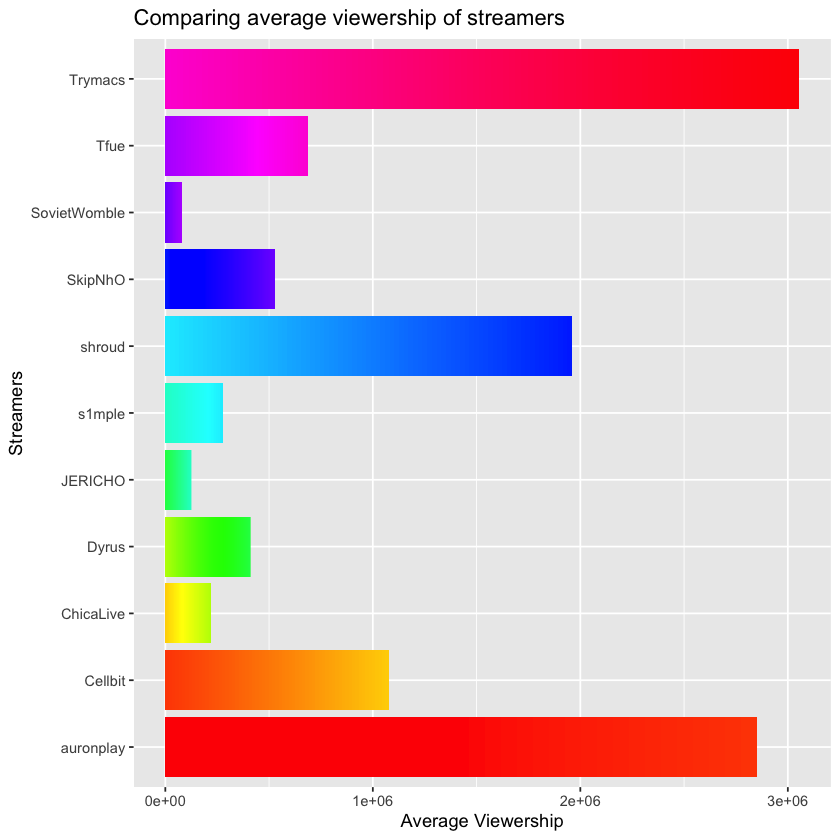

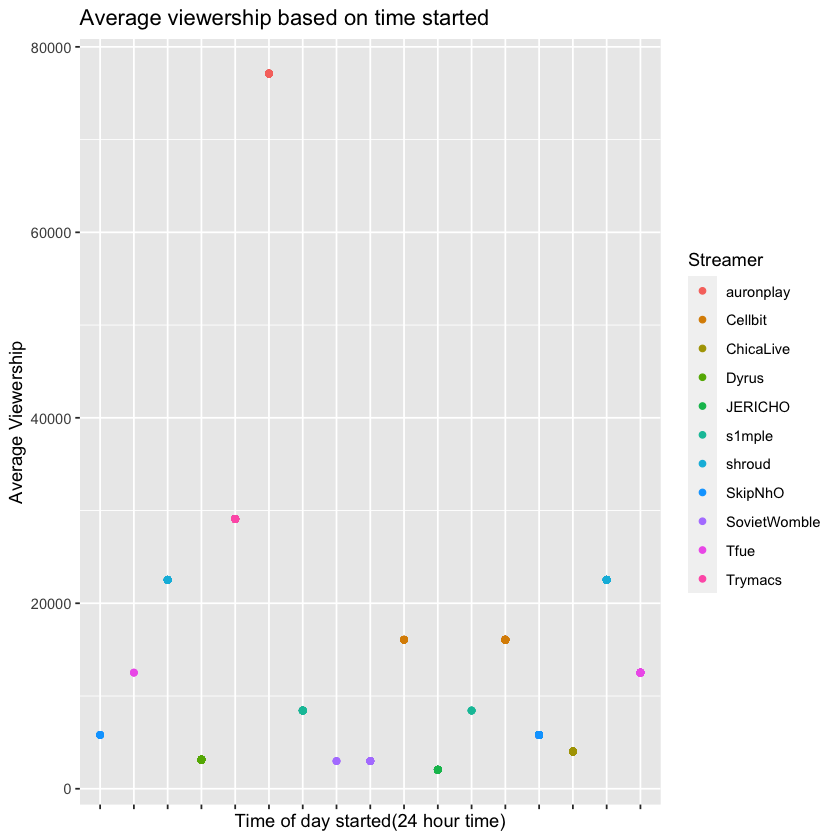

In [28]:
#makes bar plot of average veiwership for each streamer
plot1 <- ggplot(aes(ave_viewership, channel), data = final.df) + geom_bar(stat = "identity", fill = rainbow(nrow(final.df))) + ylab("Streamers") + xlab("Average Viewership") + ggtitle("Comparing average viewership of streamers")

plot1

#makes a scatterplot of time started and average viewership
plot2 <- ggplot(aes(start_time, ave_viewership, col = channel), data = final.df) + geom_point() + ylab("Average Viewership") +xlab("Time of day started(24 hour time)") + ggtitle("Average viewership based on time started") + labs(col = "Streamer") + theme(axis.text.x=element_blank())

plot2

## 
## Emote Data

### Helper Functions

In [29]:
# Helper function returns a dataframe including all emotes used in the streamers channel
emotes_from_channel <- function(streamer){
  thin <- select(chat, c(observation,channel))
  
  merged <- merge(contains, thin)
  
  return(filter(merged, channel==streamer))
}

# Helper function returns a df containing all emotes and their frequency on the channel 'streamer'
emote_frequency_in_channel <- function(streamer){
  
  merged <- emotes_from_channel(streamer)
  
  emote_count <- merged %>%
    group_by(text) %>%
    filter(channel==streamer) %>%
    summarise(N=n())
  emote_count
  sorted <-emote_count[with(emote_count, order(-N)), ]
  return(sorted)
}

# Helper function takes a vector of emotes and returns a df containing all messages with that emote present
emote_filter <- function(emote){
  tf_vec <-  contains$text %in% emote
  
  return(filter(contains, tf_vec))
}

##### 
### Plots

`summarise()` regrouping output by 'text' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



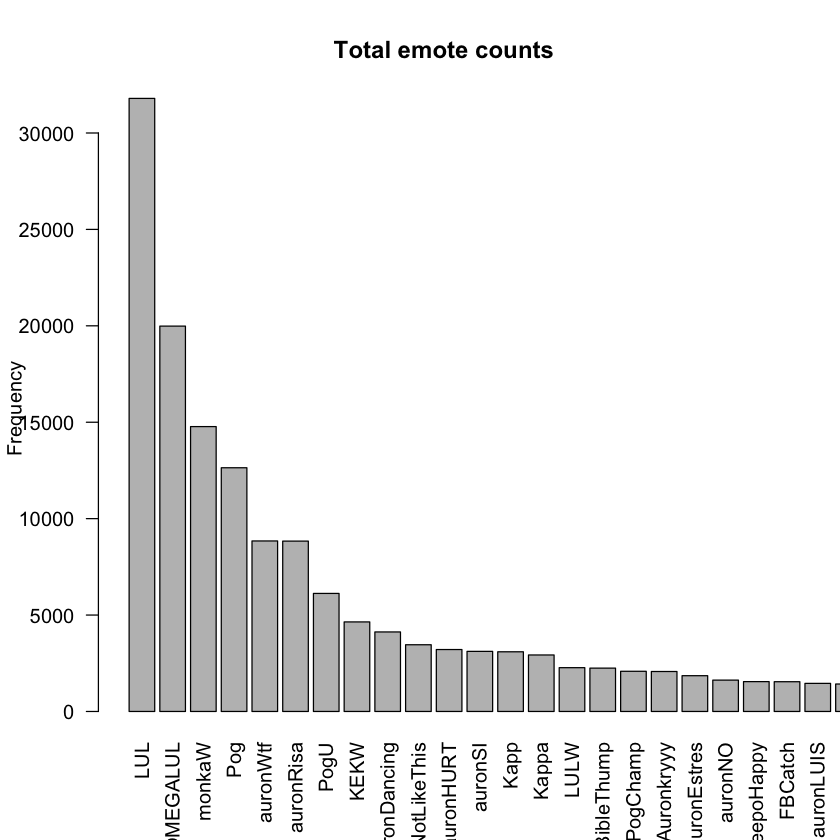

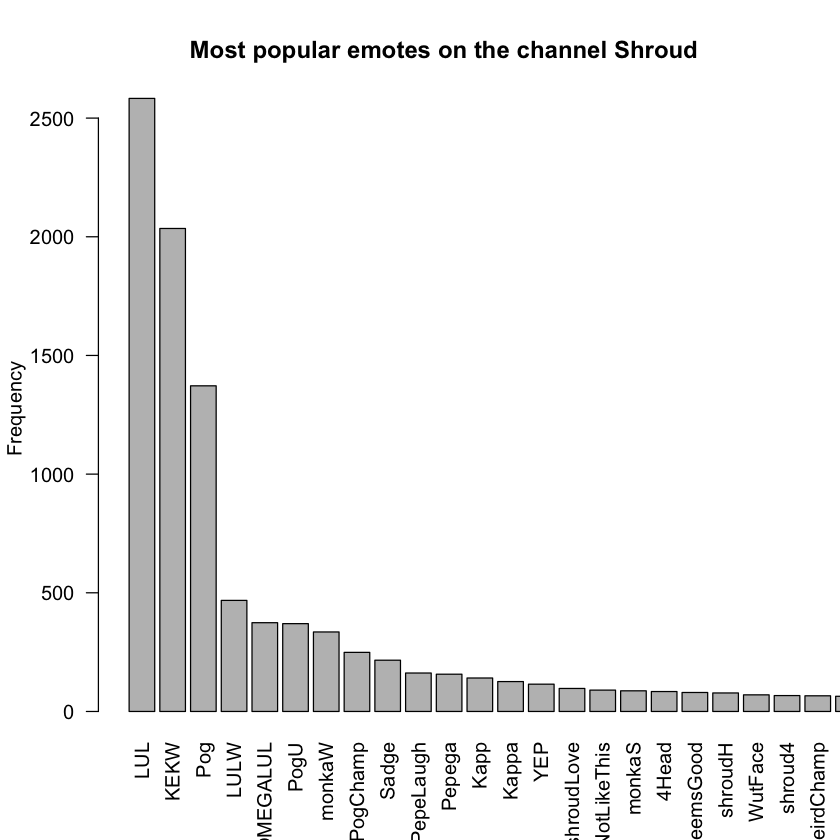

In [30]:
# Generate a emote_count variable to plot with
emote_count <- contains %>%
  group_by(text, .groups="drop") %>%
  summarise(N=n())

# Sort the emotes in ranking of popularity
sorted <-emote_count[with(emote_count, order(-N)), ]

# Plot the most popular emotes across all channels
barplot(sorted$N, xlim=c(0,25), las=2, names.arg = sorted$text, main='Total emote counts', ylab='Frequency')

# The most popular emotes used on the channel 'shroud'
shroud <- emote_frequency_in_channel("shroud")

# The most popular emotes plotted on the channel 'shroud'
barplot(shroud$N, xlim=c(0,25), las=2, names.arg = shroud$text, main='Most popular emotes on the channel Shroud', ylab='Frequency')


# Some more examples of data you can get from the helper functions
lul <- emote_filter("LUL")
shroud <- emotes_from_channel('shroud')